In [1]:
import sys
import os
import torch
sys.path.append('../denoising')
from networks import RED_CNN

In [2]:
def load_model(save_path, iter_=13000, multi_gpu=False):
    REDCNN = RED_CNN()
    f = os.path.join(save_path, 'REDCNN_{}iter.ckpt'.format(iter_))
    if multi_gpu:
        state_d = OrderedDict()
        for k, v in torch.load(f):
            n = k[7:]
            state_d[n] = v
        REDCNN.load_state_dict(state_d)
        return REDCNN
    else:
        REDCNN.load_state_dict(torch.load(f))
        return REDCNN

cnn_denoiser = load_model('../denoising/models/redcnn')
cnn_denoiser_augmented = load_model('../denoising/models/redcnn_augmented')

## Adult Human Test Set
From Held out low dose grand challenge dataset. Same clinical site and scanner as training set but different patients.

In [3]:
import pydicom
from pathlib import Path
import matplotlib.pyplot as plt

ld_dir = Path('/gpfs_projects/brandon.nelson/Mayo_LDGC/images/L506/quarter_3mm/')
fd_dir = Path('/gpfs_projects/brandon.nelson/Mayo_LDGC/images/L506/full_3mm/')
adult_ld_dcm_files = sorted(list(ld_dir.glob('*.IMA')))
adult_fd_dcm_files = sorted(list(fd_dir.glob('*.IMA')))

In [4]:
adult_ld_dcm_files[:5], adult_fd_dcm_files[:5]

([PosixPath('/gpfs_projects/brandon.nelson/Mayo_LDGC/images/L506/quarter_3mm/L506_QD_3_SHARP_1.CT.0003.0001.2016.01.21.18.23.35.89560.404744517.IMA'),
  PosixPath('/gpfs_projects/brandon.nelson/Mayo_LDGC/images/L506/quarter_3mm/L506_QD_3_SHARP_1.CT.0003.0002.2016.01.21.18.23.35.89560.404744541.IMA'),
  PosixPath('/gpfs_projects/brandon.nelson/Mayo_LDGC/images/L506/quarter_3mm/L506_QD_3_SHARP_1.CT.0003.0003.2016.01.21.18.23.35.89560.404744565.IMA'),
  PosixPath('/gpfs_projects/brandon.nelson/Mayo_LDGC/images/L506/quarter_3mm/L506_QD_3_SHARP_1.CT.0003.0004.2016.01.21.18.23.35.89560.404744589.IMA'),
  PosixPath('/gpfs_projects/brandon.nelson/Mayo_LDGC/images/L506/quarter_3mm/L506_QD_3_SHARP_1.CT.0003.0005.2016.01.21.18.23.35.89560.404744613.IMA')],
 [PosixPath('/gpfs_projects/brandon.nelson/Mayo_LDGC/images/L506/full_3mm/L506_FD_3_SHARP_1.CT.0001.0001.2016.01.21.18.23.12.612560.404533041.IMA'),
  PosixPath('/gpfs_projects/brandon.nelson/Mayo_LDGC/images/L506/full_3mm/L506_FD_3_SHARP_1.CT.

In [8]:
import SimpleITK as sitk
def load_img(dcm_file):
    if isinstance(dcm_file, sitk.Image): return sitk.GetArrayFromImage(dcm_file)
    dcm = pydicom.read_file(dcm_file)
    return dcm.pixel_array + float(dcm.RescaleIntercept)

In [9]:
def ctshow(img, wwwl=(400, 50), colorbar=True, show=True):
    if isinstance(img, str | Path | sitk.Image): img = load_img(img)
    ww, wl = wwwl
    vmin = wl - ww/2
    vmax = wl + ww/2
    f, ax = plt.subplots(dpi=300)
    im = ax.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    if colorbar: plt.colorbar(im, ax=ax)
    plt.axis('off')
    if show: plt.show()

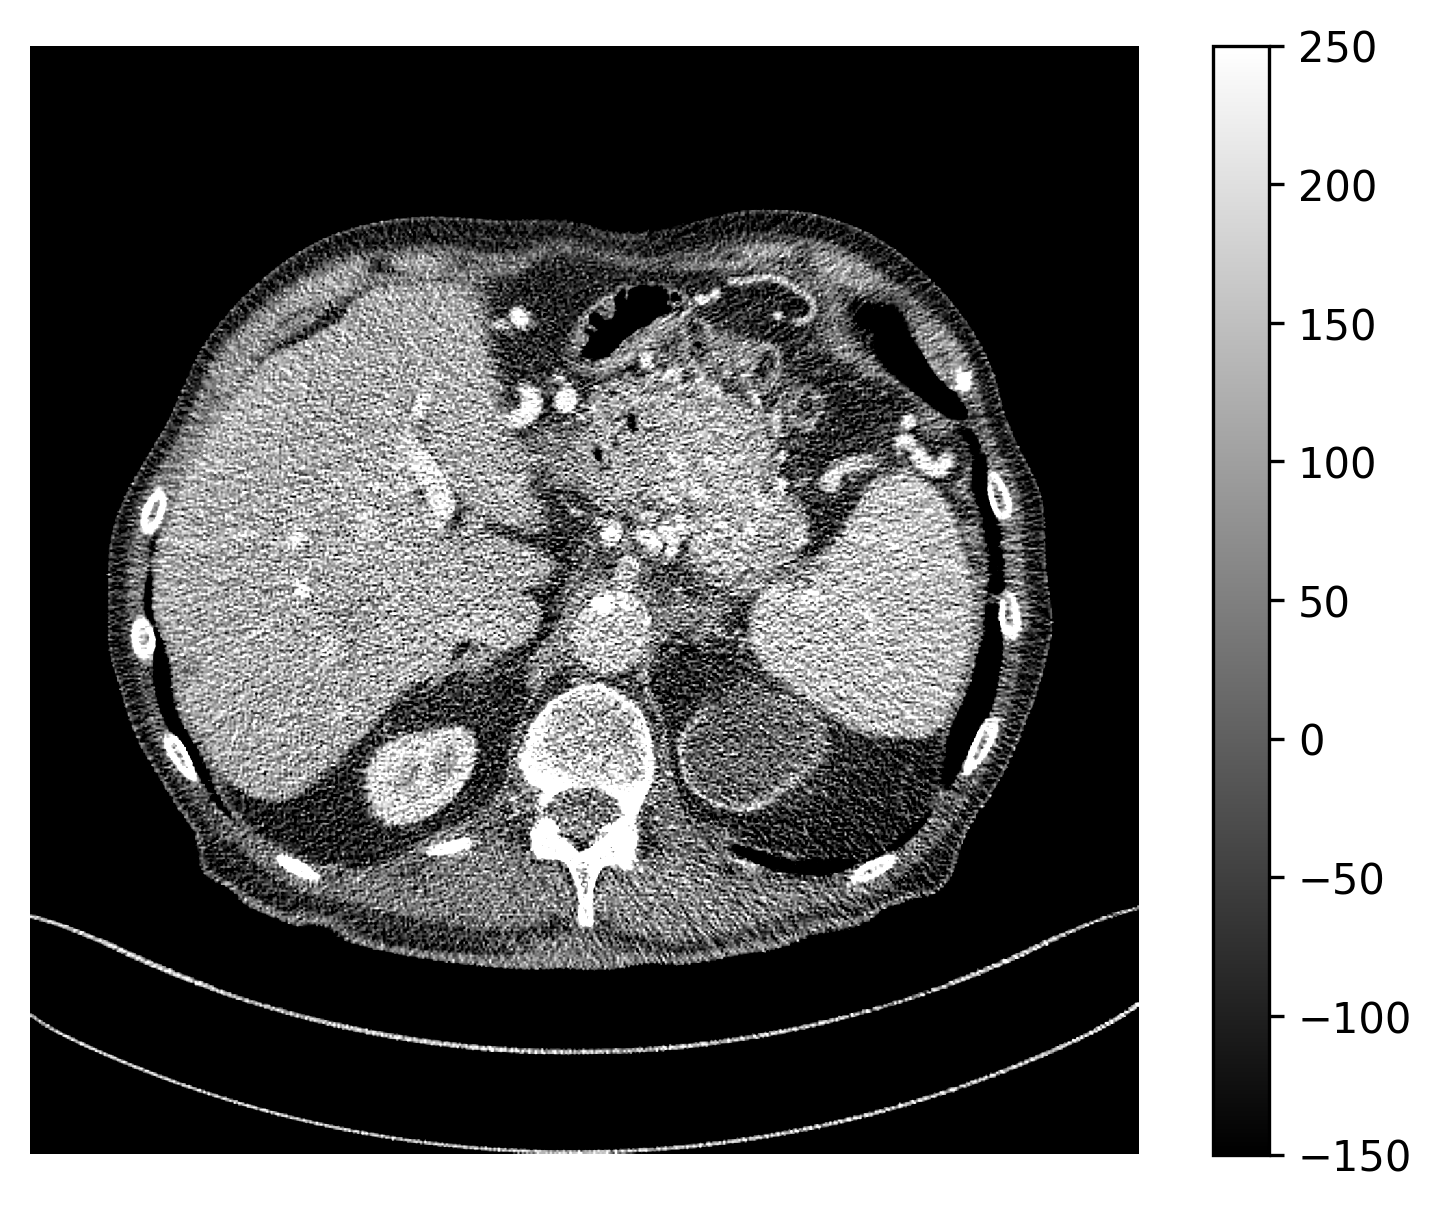

In [10]:
idx = 30
ld = load_img(adult_ld_dcm_files[idx])
rd = load_img(adult_fd_dcm_files[idx])
ctshow(ld)

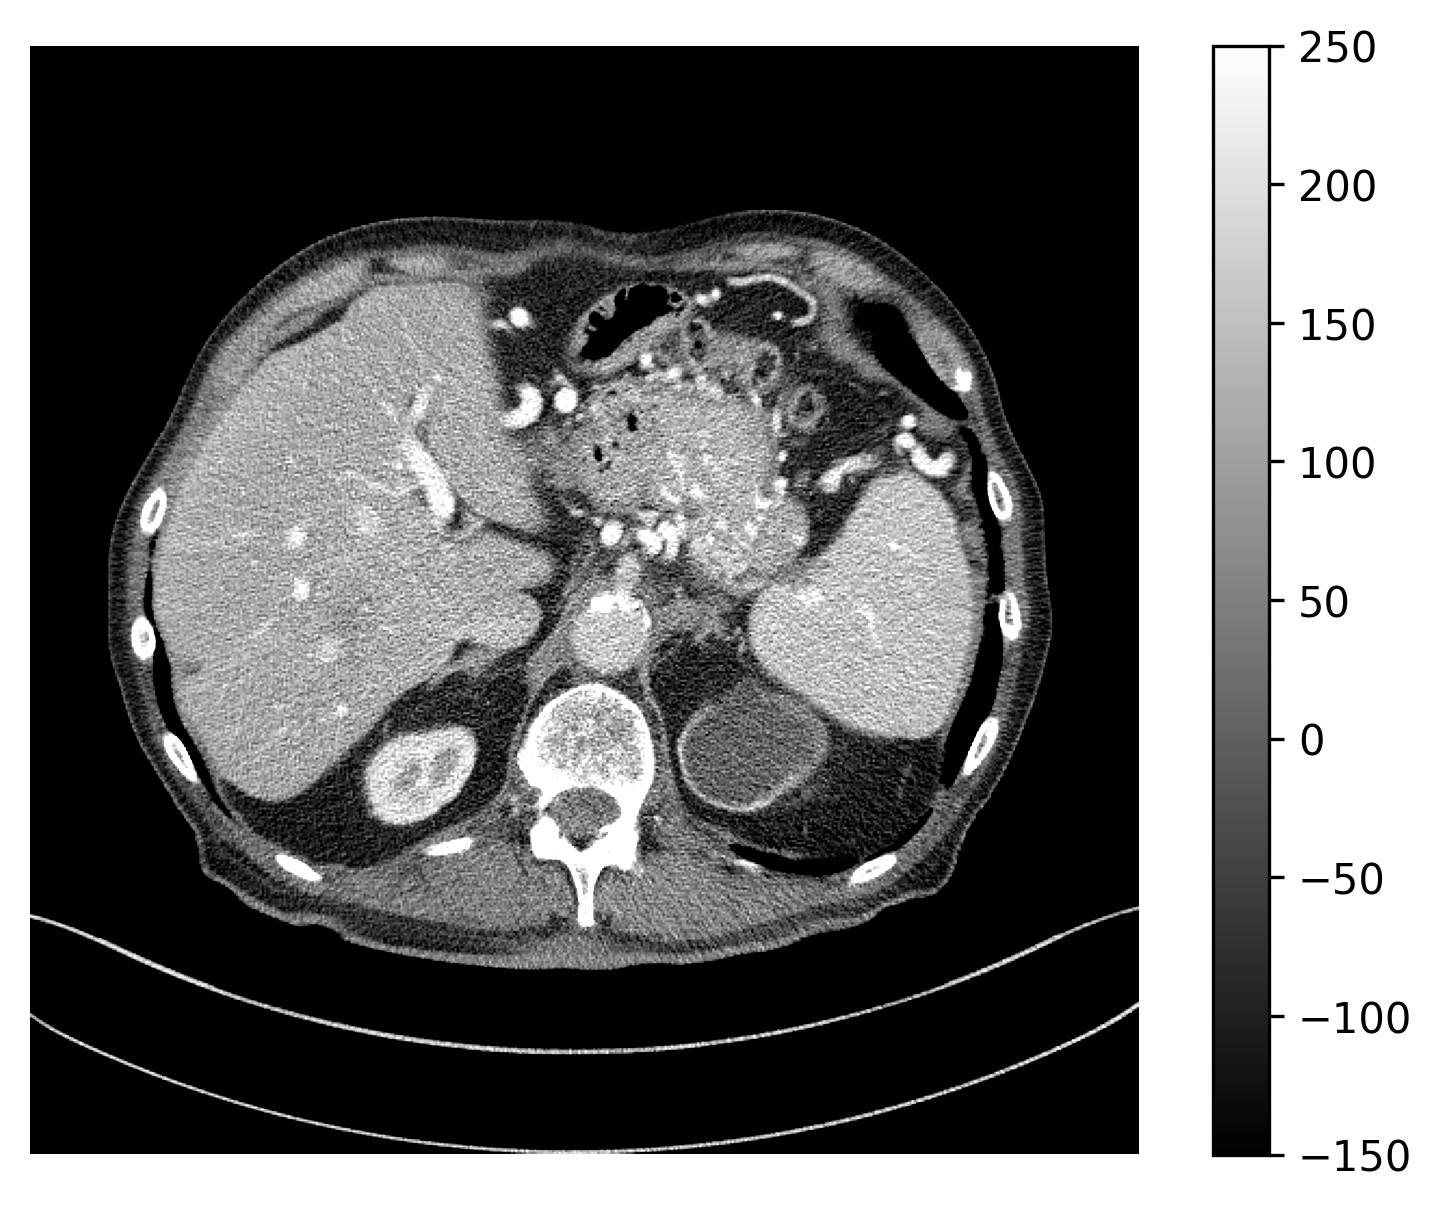

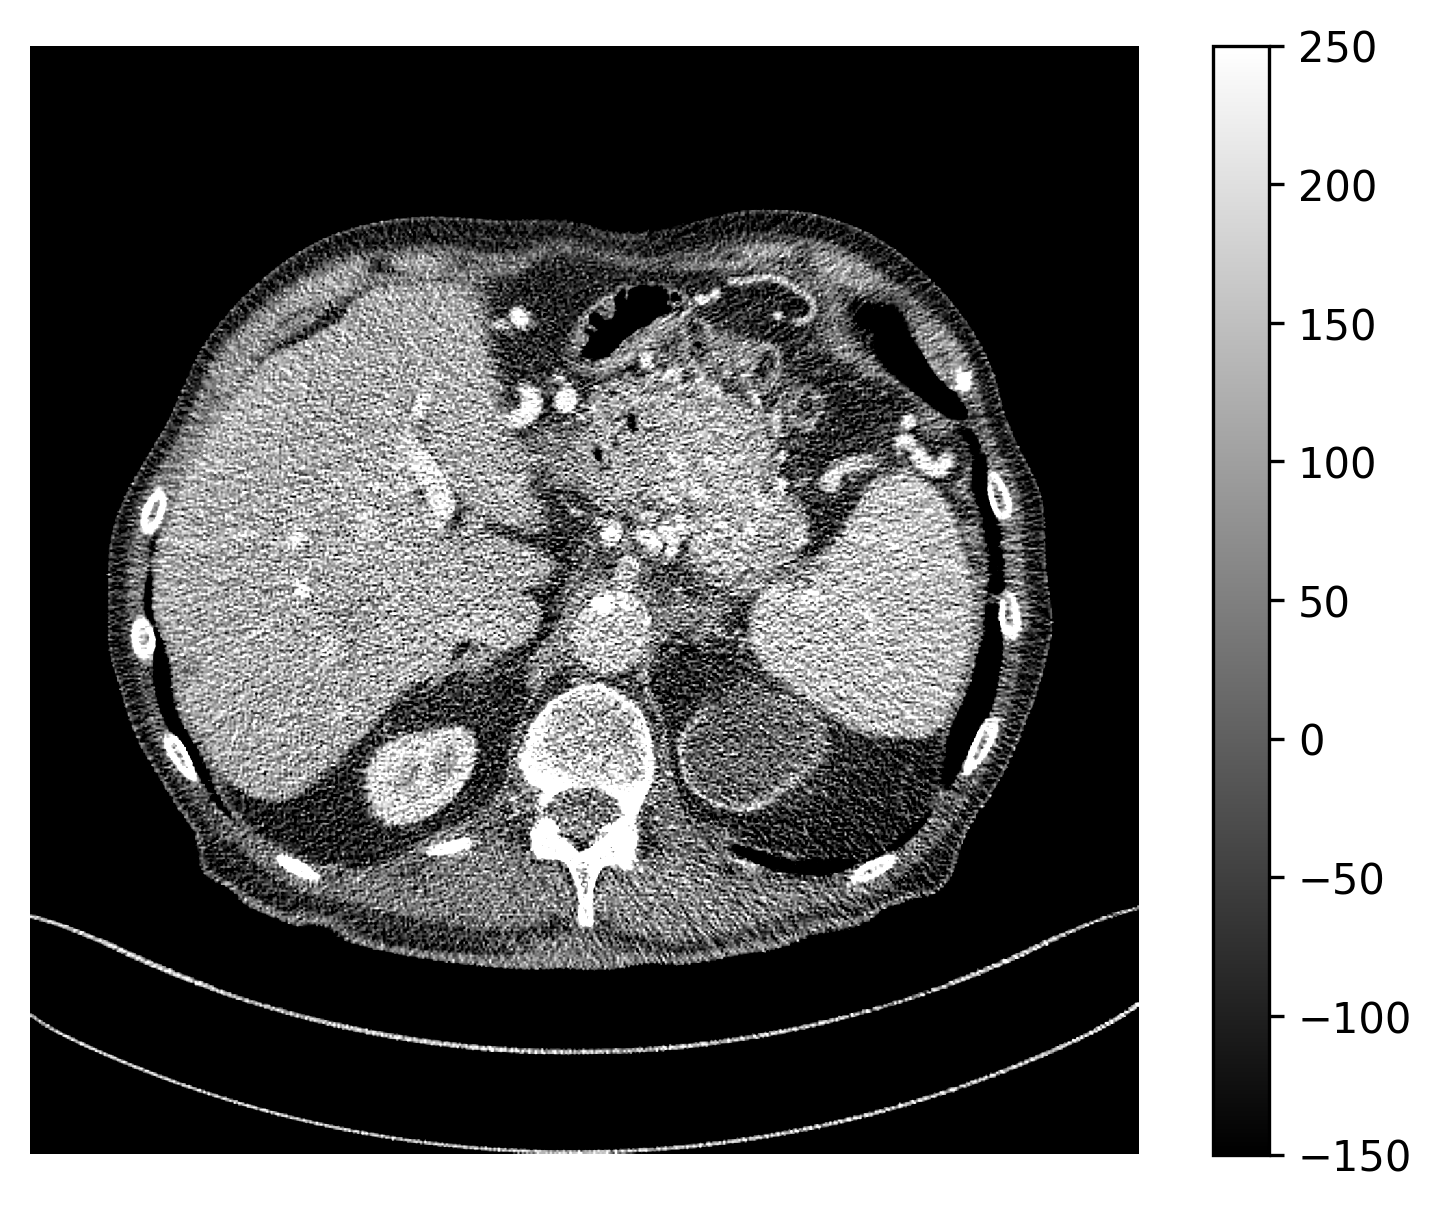

In [11]:
ctshow(adult_fd_dcm_files[idx])
ctshow(adult_ld_dcm_files[idx])

In [12]:
denoised = cnn_denoiser.predict(ld).squeeze()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


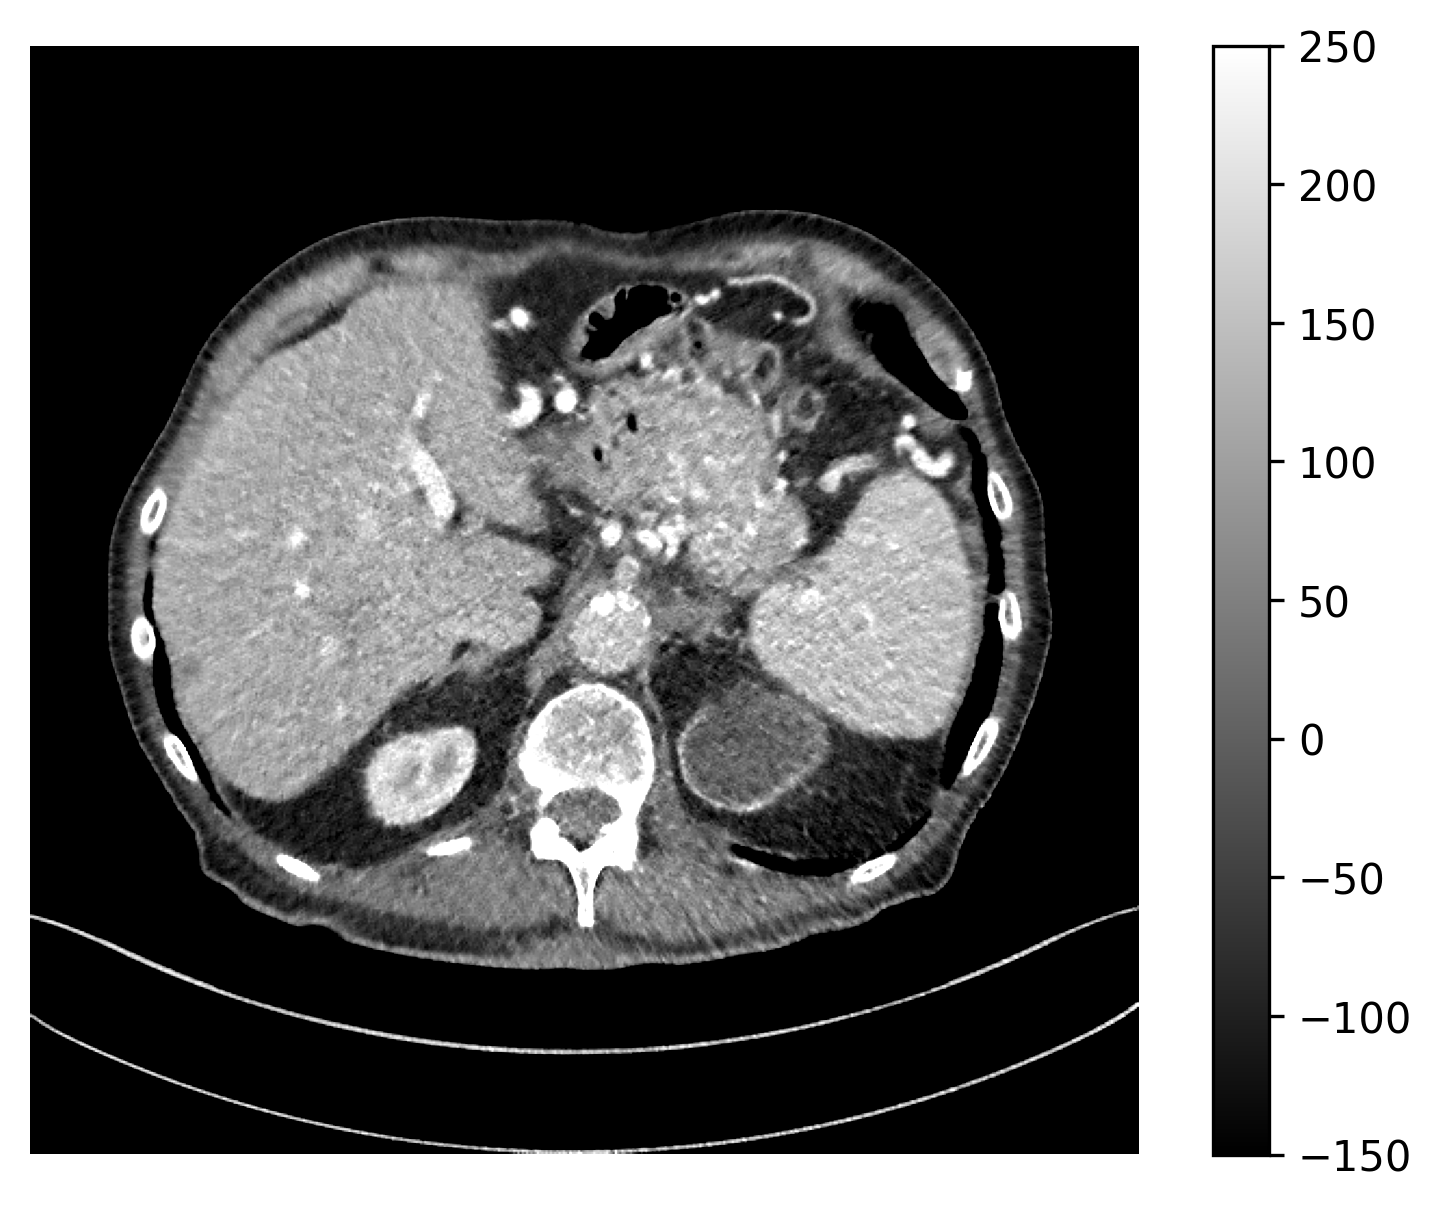

In [13]:
ctshow(denoised)

In [14]:
augmented = cnn_denoiser_augmented.predict(ld).squeeze()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


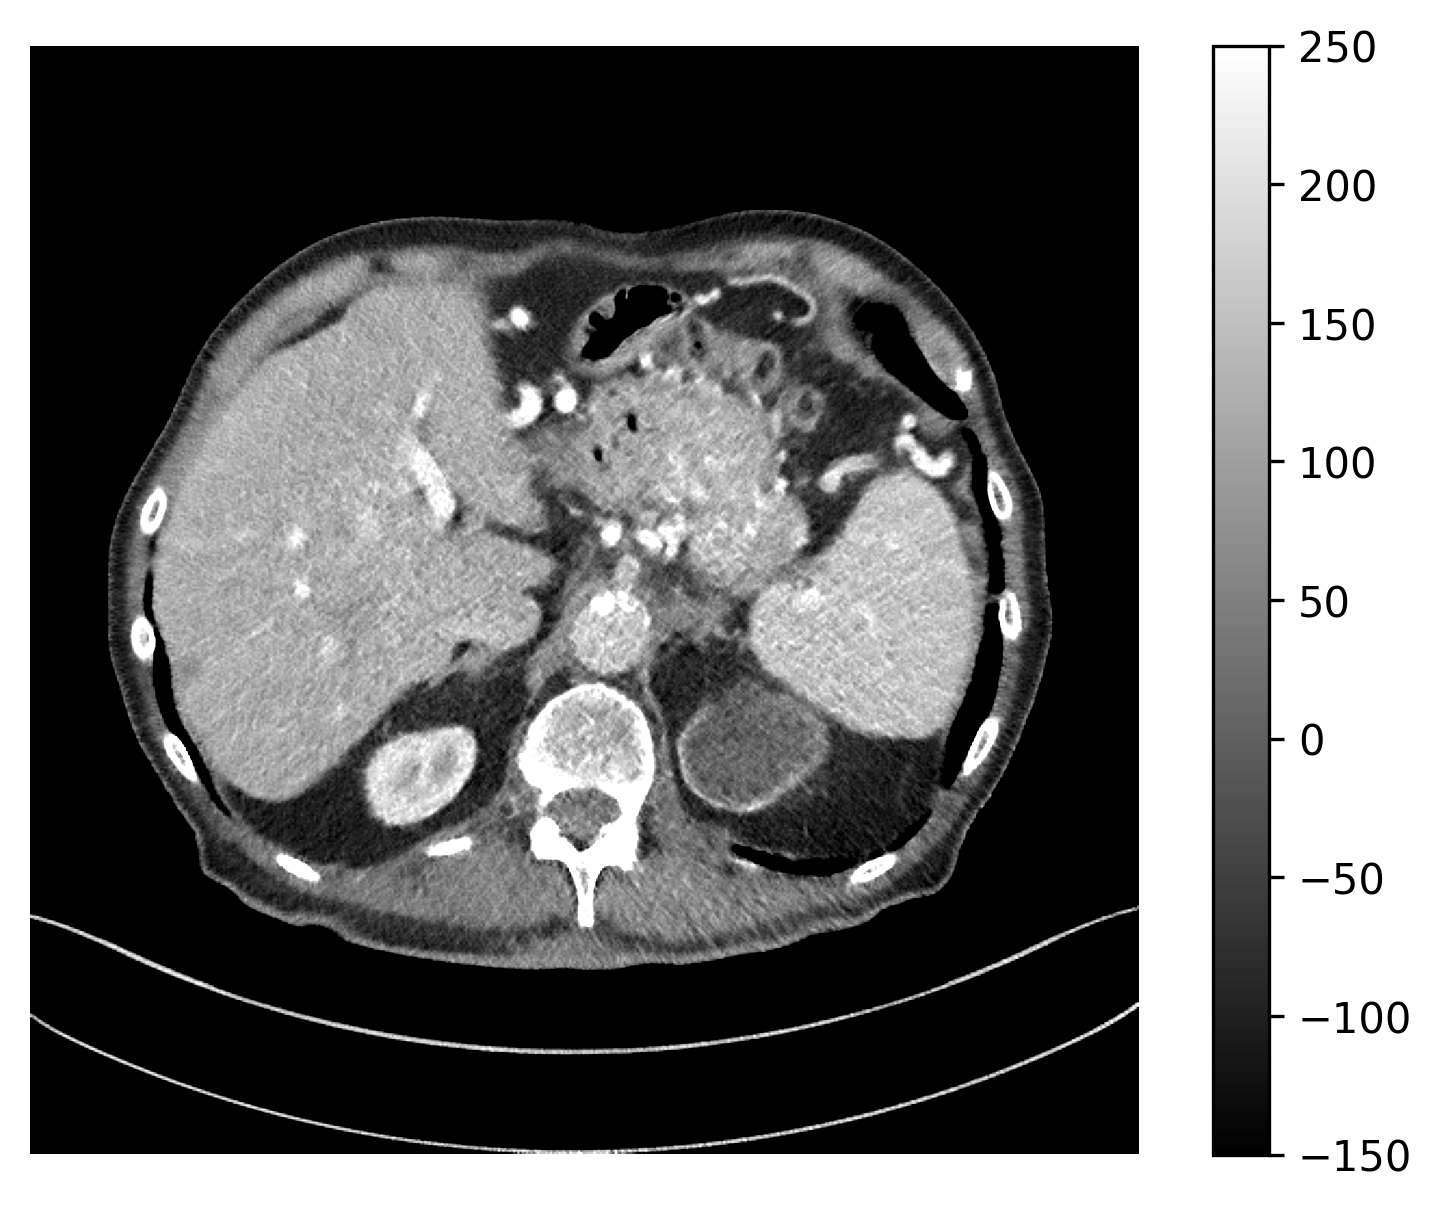

In [15]:
ctshow(augmented)

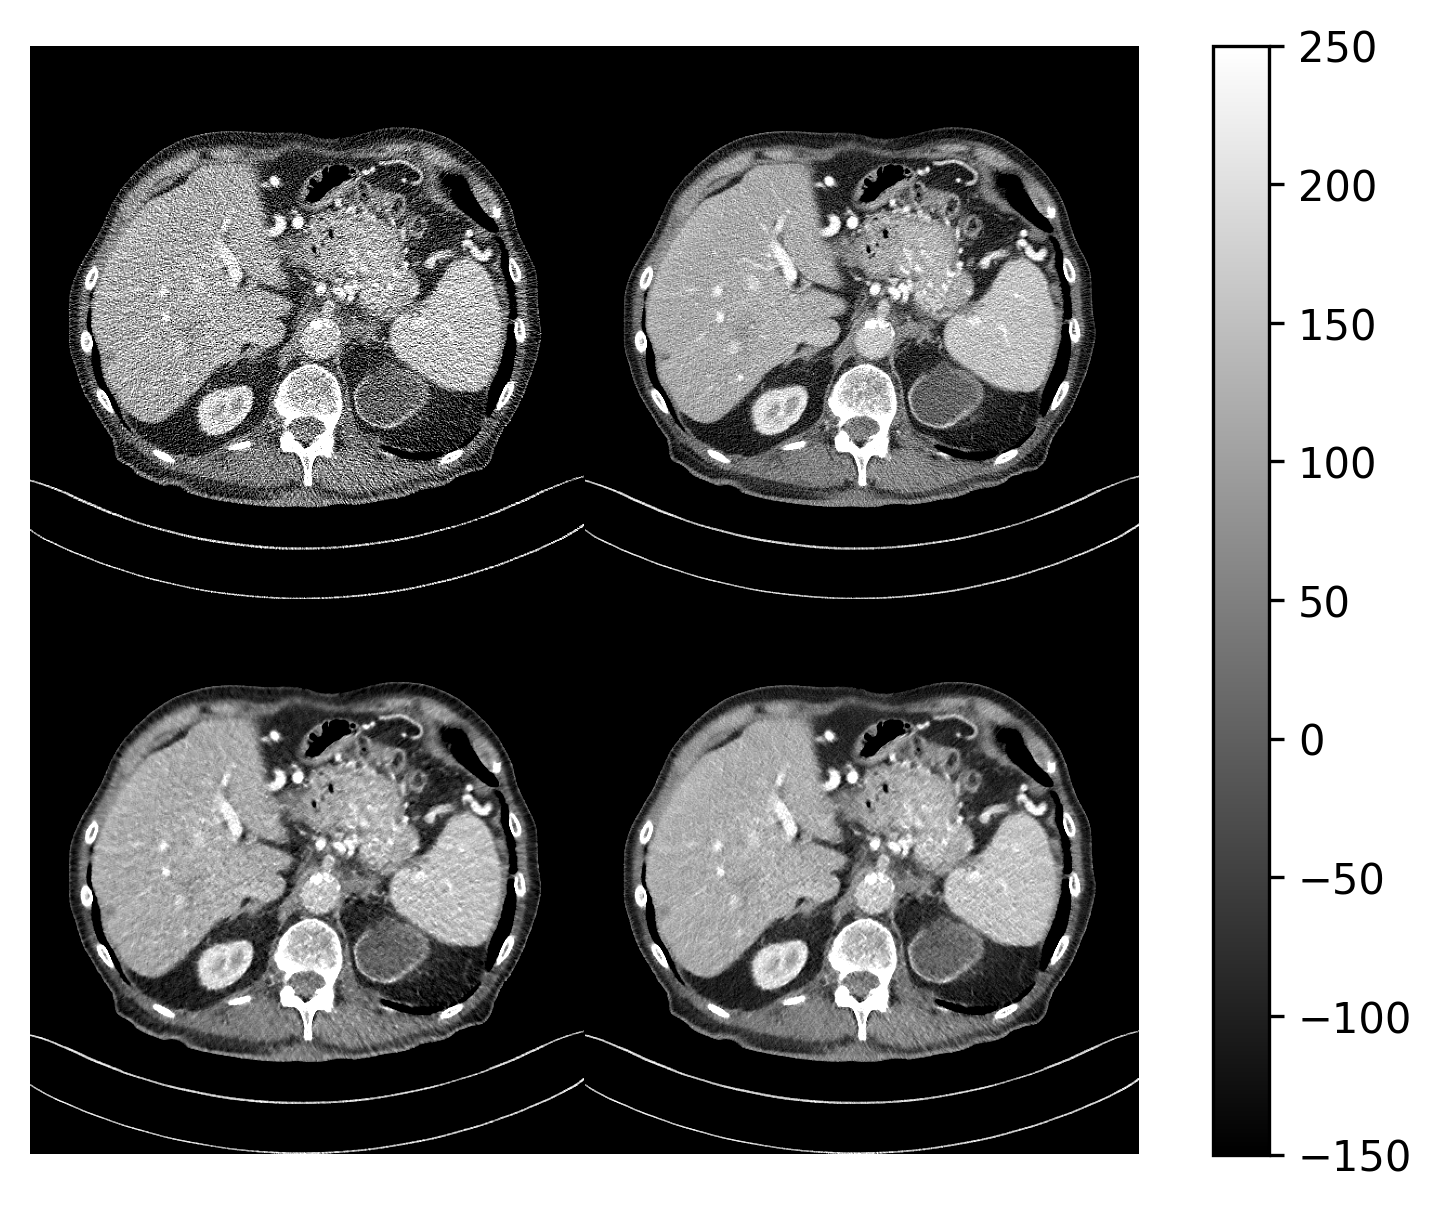

In [16]:
import numpy as np
ctshow(np.concatenate([np.concatenate([ld, rd], axis=1),
                      np.concatenate([denoised, augmented], axis=1)], axis=0))

In [ ]:
ctshow(np.concatenate([ld-rd, ld-denoised, ld-augmented],axis=1), (200, 0), colorbar=False)

In [ ]:
ctshow(np.concatenate([rd - ld, rd-denoised, rd-augmented],axis=1), (200, 0), colorbar=False)

In [ ]:
def rmse(x ,y): return np.sqrt(np.mean((x.ravel()-y.ravel())**2))

In [ ]:
rmses = {v: rmse(k, rd) for (k, v) in zip([ld, denoised, augmented], ['low dose', 'redcnn', 'redcnn-aug'])}
rmses

In [ ]:
adult_fd_images = np.array([load_img(o) for o in sorted(adult_fd_dcm_files)])
adult_ld_images = np.array([load_img(o) for o in sorted(adult_ld_dcm_files)])
adult_fd_images.shape, adult_ld_images.shape

In [ ]:
cnn_denoiser.to('cuda')
cnn_denoiser.predict(adult_ld_images[:,None,:,:], device='cuda', batch_size=32);

In [ ]:
rmse(adult_fd_images, adult_ld_images)

In [ ]:
batch_size=32
device = 'cuda'

series_rmse = ['low dose', 'redcnn', 'redcnn-aug']
res = np.zeros((len(series_rmse), len(adult_ld_dcm_files)))
adult_fd_images = np.array([load_img(o) for o in sorted(adult_fd_dcm_files)])
adult_ld_images = np.array([load_img(o) for o in sorted(adult_ld_dcm_files)])

for d_idx, (denoiser, name) in enumerate(zip([None, cnn_denoiser, cnn_denoiser_augmented], series_rmse)):
    if denoiser is None:
       res[0, :] = list(map(lambda x, y: rmse(x, y), adult_ld_images, adult_fd_images))
    else:
        denoiser.to(device)
        denoised = denoiser.predict(adult_ld_images[:, None,:,:], device=device, batch_size=batch_size).squeeze()
        res[d_idx, :] = list(map(lambda x, y: rmse(x, y), denoised, adult_fd_images))

In [ ]:
import pandas as pd

In [ ]:
rmse_df = pd.DataFrame(data=res.T, columns = series_rmse)
rmse_df['full dose file'] = str(adult_fd_dcm_files)
rmse_df['quarter dose file'] = str(adult_ld_dcm_files)
rmse_df

In [ ]:
import seaborn as sns

In [ ]:
sns.violinplot(data=rmse_df)
plt.ylabel('RMSE')

In [ ]:
sns.scatterplot(data=rmse_df,x='low dose', y='redcnn', label='redcnn')
sns.scatterplot(data=rmse_df,x='low dose', y='redcnn-aug', label='redcnn aug')
plt.legend()

The fact that the augmented model underperforms the original model when tested on *adult* data is unsurprising, our hypothesis is that it would act as a regularizer and yield more consistent performance in *smaller* patients, need to explore this next

## Phantom Test Set

Simulated using MIRT as described in [Nelson et al., 2023](https://onlinelibrary.wiley.com/doi/abs/10.1002/mp.16901) where the acquisition parameters are meant to simulate the Siemens Somatom Definition AS+, which is one of the scanners used in developing the [Low Dose CT Grand Challenge Dataset](https://aapm.onlinelibrary.wiley.com/doi/full/10.1002/mp.12345). However I still need to be careful that this is an approximation and there still may be mismatch between the real and simulated scans, though [Zeng et al., 2022](http://onlinelibrary.wiley.com/doi/abs/10.1002/mp.15430) validated the simulations with physical scans based on MTF and NPS performance measures.

*Purpose* to test our hypothesis that training with noise augmentation can improve performance

In [ ]:
import SimpleITK as sitk
signal = 'present'
dose = 100

def load_cct189(dose=25, signal='present', recon='fbp', offset=1000, diameter=292):
    p = Path(f'/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CCT189_peds/diameter{diameter}mm/{recon}/dose_{dose:03d}/signal_{signal}/signal_{signal}.mhd')
    return load_img(sitk.ReadImage(p) - offset)

d=350
idx = 0
fbp_qd_350 = load_cct189(recon='fbp', diameter=d, dose=25, offset=1000)[idx]
red_qd_350 = load_cct189(recon='RED-CNN', diameter=d, dose=25, offset=0)[idx]
redaug_qd_350 = load_cct189(recon='RED-CNN augmented', diameter=d, dose=25, offset=0)[idx]

d = 112
fbp_qd_112 = load_cct189(recon='fbp', diameter=d, dose=25, offset=1000)[idx]
red_qd_112 = load_cct189(recon='RED-CNN', diameter=d, dose=25, offset=0)[idx]
redaug_qd_112 = load_cct189(recon='RED-CNN augmented', diameter=d, dose=25, offset=0)[idx]

In [ ]:
summary = pd.read_csv('/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CCT189_peds/summary.csv')
summary

In [ ]:
summary.recon.unique(), sorted(summary['dose [%]'].unique()), sorted(summary['diameter [mm]'].unique())

In [ ]:
wwwl = (80, 40)
ctshow(np.concatenate([np.concatenate([fbp_qd_350, red_qd_350, redaug_qd_350], axis=1),
                      np.concatenate([fbp_qd_112, red_qd_112, redaug_qd_112], axis=1)], axis=0), wwwl)

In [ ]:
print([(o.mean(), o.std()) for o in [fbp_qd_350, red_qd_350, redaug_qd_350]])
print([(o.mean(), o.std()) for o in [fbp_qd_112, red_qd_112, redaug_qd_112]])

In [ ]:
print([(o[200:300, 200:300].mean(), o[200:300, 200:300].std()) for o in [fbp_qd_350, red_qd_350, redaug_qd_350]])
print([(o[200:300, 200:300].mean(), o[200:300, 200:300].std()) for o in [fbp_qd_112, red_qd_112, redaug_qd_112]])

Looks like augmentation lead to better denoising efficiency in the smaller phantom! ^^ [denoised std/fbp std] --> **[31 HU/48 HU] for REDCNN, compared to [24 HU/48 HU] for augmented!**

In [ ]:
redaug_img = sitk.GetArrayFromImage(sitk.ReadImage(summary[(summary.recon=='RED-CNN augmented') & (summary['dose [%]']==25) & (summary['diameter [mm]']==350)].filename.item()))

red_img = sitk.GetArrayFromImage(sitk.ReadImage(summary[(summary.recon=='RED-CNN') & (summary['dose [%]']==25) & (summary['diameter [mm]']==350)].filename.item()))
fbp_img = sitk.GetArrayFromImage(sitk.ReadImage(summary[(summary.recon=='fbp') & (summary['dose [%]']==25) & (summary['diameter [mm]']==350)].filename.item())).astype('float32') - 1000
add_back = red_img + 0.35*(fbp_img - red_img)

Need to confirm that training side data augmentation is not inferior to just adding back some noise as done above^

In [ ]:
wwwl = (100, 20)
ctshow(np.concatenate([fbp_img[0], red_img[0], add_back[0], redaug_img[0]], axis=1), wwwl)

In [ ]:
wwwl = (100, 20)
ctshow(np.concatenate([fbp_img[0]-fbp_img[1], red_img[0]-red_img[1], add_back[0]-add_back[1], redaug_img[0]-redaug_img[1]], axis=1), wwwl)

In [ ]:
[o.std() for o in [fbp_img[0]-fbp_img[1], red_img[0]-red_img[1], add_back[0]-add_back[1], redaug_img[0]-redaug_img[1]]]

Interesting that adding back 0.35 the fbp noise results in higher magnitude noise rather incorporating it into training, which makes sense since the data augmentation in training is a regularization worknig against the optimizer. Note that we don't expect noise magnitude to benefit, but rather the texture, however by directly adding back FBP noise we more easily capture that texture but at the expense of elevated noise magnitude and it requires doing multiple recon steps vs just one if that texture is backed into the model. Ultimately I still want to know whether a peds only model can do better

```python
   def augment(self, image_label, aug_thresh=0.65):
        image, label = image_label
        noise_patch = self.noise_patches[torch.randperm(len(image))].reshape_as(image)
        noise_lambda = torch.rand([1])[0].item() # adds a random amount of noise, consider ablating to see affect with and without this (seems similar to the noise level augmentation which was generally beneficial whereas having it off would be just augmenting with a single noise level (equal to quarter dose but with different texture))
        add_noise = torch.rand([1])[0].item() > aug_thresh #from 0.5
```

In [ ]:
[o.mean() for o in [fbp_img[0]-fbp_img[1], red_img[0]-red_img[1], add_back[0]-add_back[1], redaug_img[0]-redaug_img[1]]]